# Brain Tumor Detection
by Dominik Römer - [LinkedIn](https://https://www.linkedin.com/in/dominik-r%C3%B6mer-7a4185141/)
---



## Introduction


> According to the american National Brain Tumor Society([Link](https://braintumor.org/brain-tumors/about-brain-tumors/brain-tumor-facts/#:~:text=Today%2C%20an%20estimated%20700%2C000%20people,patient%20and%20their%20loved%20ones.)) 700,000 peaople in the US having a primary brain tumor and in the year 2022 approximatly 89,000 will receive a tumor diagnose and in this [article](https://www.clinicaltrialsarena.com/comment/brain-cancer-us-ageing-population/#:~:text=GlobalData%20epidemiologists%20forecast%20an%20increase,(AGR)%20of%201.50%25.) they are claiming that the number of diagnosed cases will increase from 27,000 in 2020 to 31,000 in 2030 in the US.

> In general, spotting cancer early increases the chances of survival, says the Cacer Research UK [(Link)](https://www.cancerresearchuk.org/about-cancer/cancer-symptoms/why-is-early-diagnosis-important) and with increasing numbers it is important to find solutions for early, precise and fast tumor detection.  AI and especially Deep Learning is increaingly included in the medical diagnosis processes and the advantages of image classification with deep learning can be used to make the diagnosis task more efficient. Instead of a doctor going through all the scans of a MRT a deep learning network could do a pre selection and the doctor would just need to watch through a few scans instead of the whole batch.  




## Libraries

In [2]:
import pandas as pd
from google.colab import drive
import os

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import PIL
import PIL.Image as Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

import pathlib
import glob

from IPython.display import clear_output

## Presettings

In [3]:
# figure presettings
fig_size = (10, 10)
fige_title_fontsize = 16

# train/valid/test split
train = 0.6
val = 0.2
test = 0.2

## Load data

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
os.path.abspath(os.getcwd())


'/content'

In [6]:
train_data_path = '/content/drive/MyDrive/data_science/projects/brain_tumor_detection/data/train'
test_data_path = '/content/drive/MyDrive/data_science/projects/brain_tumor_detection/data/test'

In [7]:

neg_data_dir = pathlib.Path(train_data_path+'/negative')
pos_data_dir = pathlib.Path(train_data_path+'/positive')

neg_img_list = list(neg_data_dir.glob('*.jpg'))+list(neg_data_dir.glob('*.jpeg'))+list(neg_data_dir.glob('*.JPG'))
pos_img_list = list(pos_data_dir.glob('*.jpg'))+list(pos_data_dir.glob('*.jpeg'))+list(pos_data_dir.glob('*.JPG'))  

neg_count = len(neg_img_list)
pos_count = len(pos_img_list)
print('number of tumor negative images: {:d}'.format(neg_count))
print('number of tumor positive images: {:d}'.format(pos_count))

number of tumor negative images: 87
number of tumor positive images: 145


## Data Insights

Examples of a brain without tumor

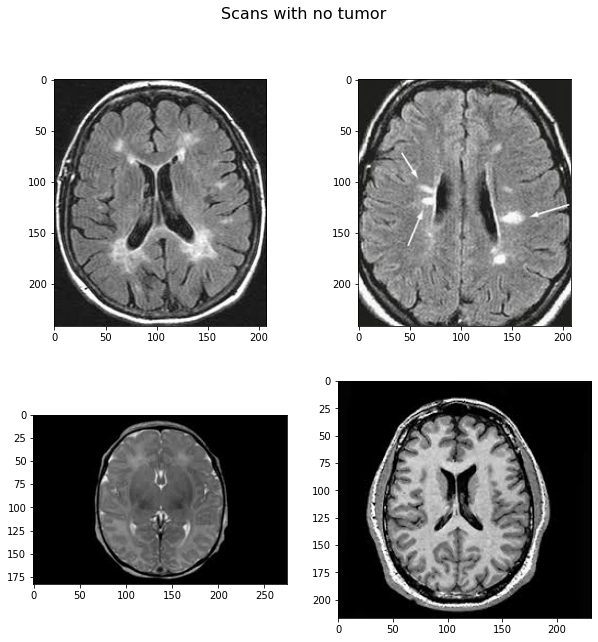

In [8]:
#neg_images = list(neg_data_dir.glob('*.jpg'))
num_examples = 4

fig = plt.figure(figsize=(10, 10))
fig.suptitle('Scans with no tumor', fontsize=fige_title_fontsize)
for i in range(1, num_examples+1):
  ax = plt.subplot(2, 2, i)
  ax.imshow(mpimg.imread(neg_img_list[i-1]))



Example of brain with tumor

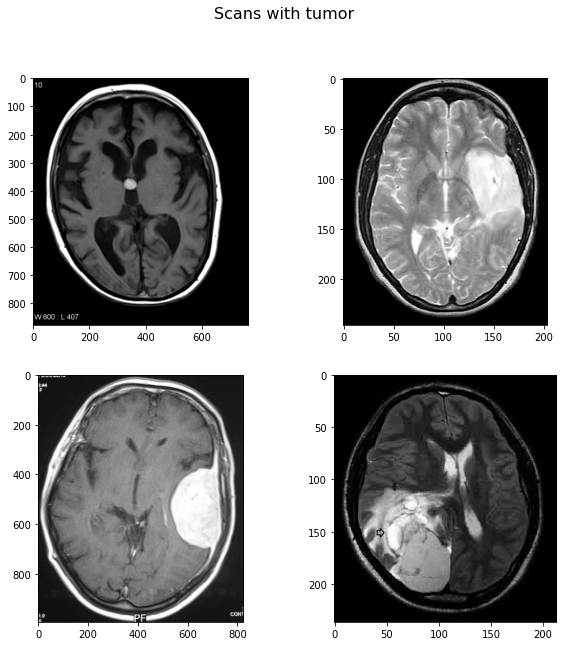

In [9]:
# pos_images = list(pos_data_dir.glob('*.jpg'))

fig = plt.figure(figsize=fig_size)
fig.suptitle('Scans with tumor', fontsize=fige_title_fontsize)
for i in range(1, num_examples+1):
  ax = plt.subplot(2, 2, i)
  ax.imshow(mpimg.imread(pos_img_list[i-1]))

In [10]:
img = Image.open(neg_img_list[0])
print(np.array(img).shape)


(242, 208, 3)



*   The pictures have different shapes
*   Some pictures have other objects like arrows or writing in it

**Get a deeper insight into the meta data of the images** 

> A dataframe is crated to store all the information.



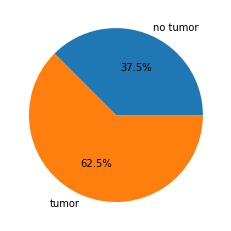

In [11]:
fig = plt.figure()
plt.pie([len(neg_img_list), len(pos_img_list)], labels=['no tumor', 'tumor'], autopct='%1.1f%%')
plt.show()

In [12]:
image_heights = []
image_widths = []
filenames = []
image_ratio = []

image_meta_df = {}
for image in neg_img_list+pos_img_list:
  filenames.append(image.name.split('/')[-1])
  height = np.array(Image.open(image)).shape[0]
  width = np.array(Image.open(image)).shape[1]
  image_heights.append(height)
  image_widths.append(width)
  image_ratio.append(height/width)

image_meta_df = pd.DataFrame({
    'filename': filenames,
    'height': image_heights,
    'width': image_widths,
    'ratio': image_ratio
  }
)
image_meta_df.describe()

,height,width,ratio
count,232.000000,232.000000,232.000000
mean,383.866379,347.543103,1.118629
std,209.787430,192.930573,0.148765
min,168.000000,150.000000,0.560000
25%,250.750000,225.000000,1.000000
50%,331.000000,278.500000,1.139198
75%,431.000000,383.250000,1.225877
max,1427.000000,1275.000000,1.465300


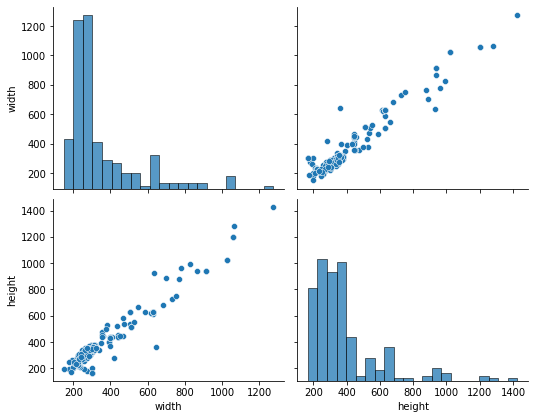

In [13]:
pp = sns.pairplot(image_meta_df[['width', 'height']])
pp.fig.set_size_inches(8, 6)
plt.show()

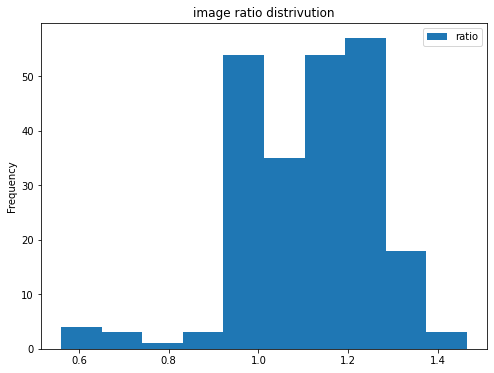

In [14]:

image_meta_df[['ratio']].plot(kind='hist', figsize=(8, 6))
plt.title('image ratio distrivution')
plt.show()


In [15]:
print(f'median of image height: {np.median(image_meta_df["height"])}')
print(f'median of image width: {np.median(image_meta_df["width"])}')

median of image height: 331.0
median of image width: 278.5




*   The scatter plots and the ratio distribution histogram show that a lot of the pictures have a ratio near 1, so lets keep a ratio of 1
*   Downscaling the few big pictures seem to be a better way to go than to upscaling the many smaller ones


## Data Preprocessing

Load all the pcitures


In [40]:
batch_size = 20

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_path,
    subset='training',
    seed=42,
    batch_size=batch_size,
    validation_split=0.30,
    shuffle=True
)


valid_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_path,
    subset='validation',
    seed=42,
    batch_size=batch_size,
    validation_split=0.30,
    shuffle=True
)


test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_path,
    batch_size=batch_size,
    shuffle=False,
    seed=42,
)


Found 234 files belonging to 2 classes.
Using 164 files for training.
Found 234 files belonging to 2 classes.
Using 70 files for validation.
Found 19 files belonging to 2 classes.


**Bring all images to the same format**

In [41]:
# resizing and scaling
image_size = 256

def scale_data(ds):
  # prepare the dataset. If augment is True the dataset will be augmented with the predfeined functions
  resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(image_size, image_size),
    layers.Rescaling(1./255)
  ])
  return ds.map(lambda x, y: (resize_and_rescale(x), y))


scaled_train_ds = scale_data(train_ds)
scaled_valid_ds = scale_data(valid_ds)
scaled_test_ds = scale_data(test_ds)

image_batch, labels_batch = next(iter(scaled_valid_ds))
print(f'shape of an image: {image_batch[0].shape}')

shape of an image: (256, 256, 3)


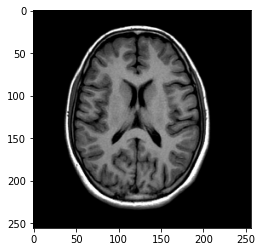

In [18]:
example_idx = 1
fig = plt.figure()
plt.imshow(image_batch[example_idx])
plt.show()

**Data augmentation**


In [19]:



# resizing and scaling
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(image_size, image_size),
  layers.Rescaling(1./255)
])



## Model Training


**Presettings**


In [49]:
epochs = 25

#optimizer 
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


**Defining callback functions for training**

In [33]:
class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """

    def on_train_begin(self, logs={}):
        self.metrics = {}
        self.train_loss_per_epoch = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        


        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()


        plt.tight_layout()
        plt.show()

        
callbacks_list = [PlotLearning()]

### Build model

In [24]:
input_shape = image_batch[0].shape

# set up the model structure
model = tf.keras.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.Dropout(0.4),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  tf.keras.layers.Dense(128, activation="relu"),
  layers.Dropout(0.4),
  layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 dropout (Dropout)           (None, 60, 60, 64)       

In [27]:
# compile model
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy']
)

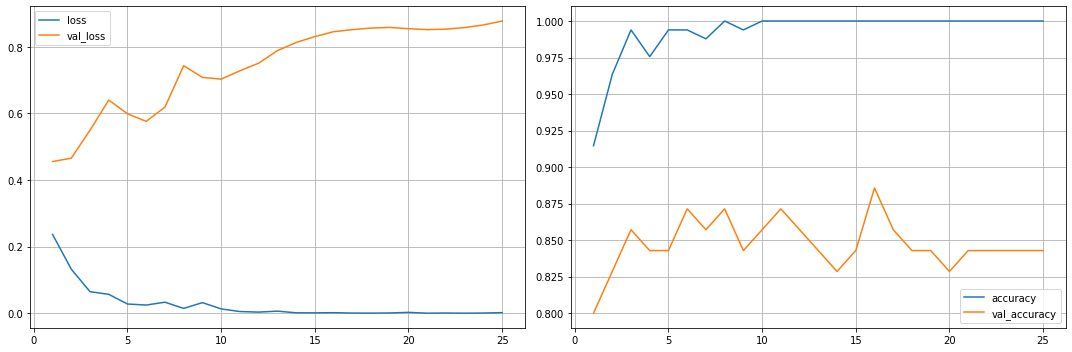

9/9 [==============================] - 22s 2s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.8773 - val_accuracy: 0.8429


In [47]:
# fit model
model_history = model.fit(scaled_train_ds, 
                    epochs=epochs,
                    validation_data=scaled_valid_ds,
                    callbacks=callbacks_list)

In [48]:
print(model.evaluate(scaled_test_ds))

1/1 [==============================] - 1s 586ms/step - loss: 0.3056 - accuracy: 0.8947
[0.30563250184059143, 0.8947368264198303]


### Conclusion


> With the validation loss iincreasing, the model is clearly underfitting. The next step is to augment the training dataset



### Data augmentation

In [29]:
# augmenting data
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

def augment_data(ds):

  ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y))
  return ds

In [31]:
aug_train_ds = augment_data(scaled_train_ds)

**train model again with augmented data**

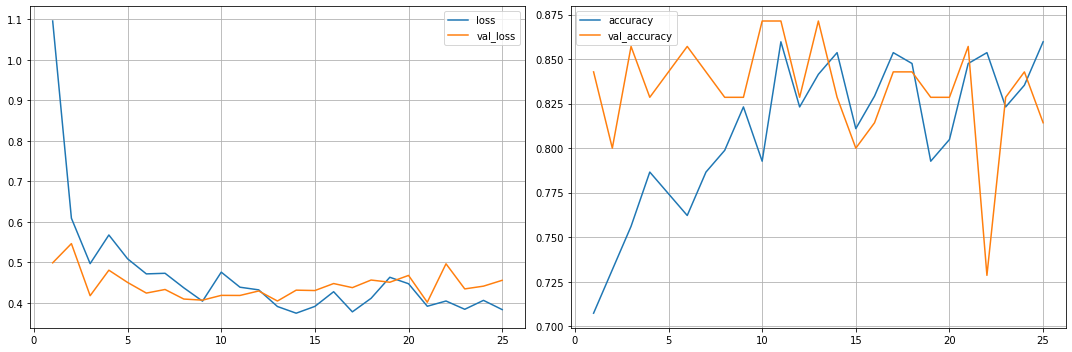

9/9 [==============================] - 21s 2s/step - loss: 0.3836 - accuracy: 0.8598 - val_loss: 0.4559 - val_accuracy: 0.8143


In [32]:
# fit model
# compile model
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy']
)


aug_model_history = model.fit(aug_train_ds, 
                    epochs=epochs,
                    validation_data=scaled_valid_ds,
                    callbacks=callbacks_list)

In [43]:
aug_model_history.evaluate(scaled_test_ds)

1/1 [==============================] - 1s 850ms/step - loss: 0.4021 - accuracy: 0.7895


[0.4021283686161041, 0.7894737124443054]

### Conclusion


> The model is not overfittign anymore so it is more stable, but the loss doesn´t decrease after a few epochs. This means the model is now underfitting and need to be more complex.



### Transferlearning with VGG19

In [44]:
base_vgg19_model = tf.keras.applications.vgg19.VGG19(
    include_top=False,
    input_shape = (image_size, image_size, 3),
    weights='imagenet',
)

base_vgg19_model.trainable = False
model_vgg19_v1 = tf.keras.Sequential([
    base_vgg19_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ]
)


80134624/80134624 [==============================] - 1s 0us/step


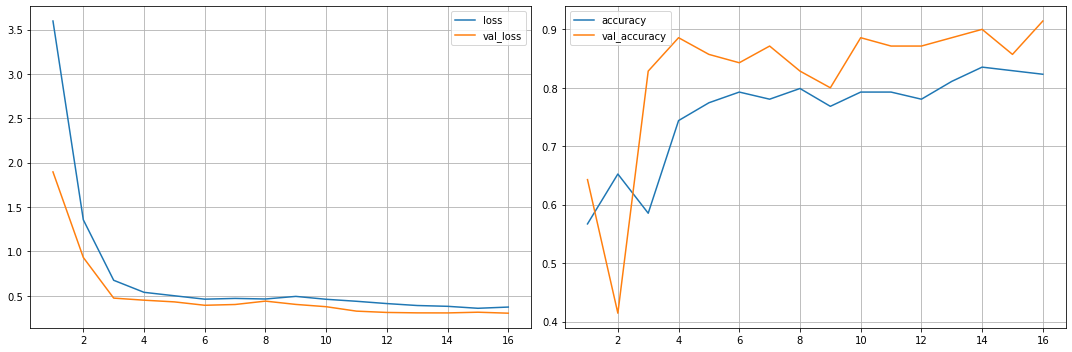

9/9 [==============================] - 209s 24s/step - loss: 0.3724 - accuracy: 0.8232 - val_loss: 0.3033 - val_accuracy: 0.9143
Epoch 17/25
9/9 [==============================] - ETA: 0s - loss: 0.3317 - accuracy: 0.8476 

In [ ]:
# compile model
model_vgg19_v1.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# model fit
model_vgg19_v1_history = model_vgg19_v1.fit(aug_train_ds,
                    epochs=epochs,
                    validation_data=scaled_valid_ds,
                    callbacks=callbacks_list) 

In [ ]:
for images, labels in prep_test_ds.take(-1):  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
print(numpy_labels)

In [ ]:
prediction = model.predict(prep_test_ds)
print(prediction)
loss=tf.keras.losses.BinaryCrossentropy(from_logits=False)

performance = loss(numpy_labels, prediction).numpy()
performance